In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
from sklearn.preprocessing import Imputer
#设置填充器  填充缺失数据
imp = Imputer(missing_values='NaN',strategy='median',axis=0,verbose=0,copy=True)

D:\anaconda\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#加载数据  小规模数据试验   7000样本中5000为训练集（做5折交叉验证）  2000为测试集
df = pd.read_csv('clean_data\FeatureEngineering_LightGBM_train.csv',nrows=7000)

In [4]:
df.head(10)

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,isFraud
0,2987000,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,...,819269,446307,450258,517251,449555,6,6,6,6,0
1,2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,...,819269,446307,450258,517251,449555,4,0,6,6,0
2,2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,...,819269,446307,450258,517251,449555,5,0,6,6,0
3,2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,...,819269,446307,450258,517251,449555,9,0,6,6,0
4,2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,...,267353,19555,1061,544,134066,4,0,6,6,0
5,2987005,49.0,4,5937,555.0,150.0,4,226.0,2,272.0,...,819269,446307,450258,517251,449555,4,0,6,6,0
6,2987006,159.0,4,12308,360.0,150.0,4,166.0,2,126.0,...,819269,446307,450258,517251,449555,9,0,6,6,0
7,2987007,422.5,4,12695,490.0,150.0,4,226.0,2,325.0,...,819269,446307,450258,517251,449555,7,0,6,6,0
8,2987008,15.0,1,2803,100.0,150.0,4,226.0,2,337.0,...,267353,82170,13423,6447,134066,7,0,6,6,0
9,2987009,117.0,4,17399,111.0,150.0,2,224.0,2,204.0,...,819269,446307,450258,517251,449555,9,0,6,6,0


In [5]:
data=np.array(df)
print(data.shape)
data = imp.fit_transform(data)
print(data.shape)

(7000, 337)
(7000, 337)


In [6]:
print(data[:10,:])

[[2.987000e+06 6.850000e+01 4.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]
 [2.987001e+06 2.900000e+01 4.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]
 [2.987002e+06 5.900000e+01 4.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]
 ...
 [2.987007e+06 4.225000e+02 4.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]
 [2.987008e+06 1.500000e+01 1.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]
 [2.987009e+06 1.170000e+02 4.000000e+00 ... 6.000000e+00 6.000000e+00
  0.000000e+00]]


In [7]:
#分离训练样本和测试样本    以及它们的样本和标签
X_train=data[:5000,:-1]
print(X_train.shape)
y_train=data[:5000,-1]
print(y_train.shape)
X_test=data[5000:,:-1]
print(X_test.shape)
y_test=data[5000:,-1]
print(y_test.shape)

(5000, 336)
(5000,)
(2000, 336)
(2000,)


In [8]:
"""模型1    使用svm   超参数：C, gamma, kernel"""
#训练模型1  使用svm
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_svm(X_train,y_train,X_test,y_test,C_values,gamma_values,kernel_values):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X_train, y_train)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #print(fold_n,train_index,valid_index)
        #创建模型
        clf=svm.SVC(C=C_values, gamma=gamma_values,kernel=kernel_values,probability=True) 
        #训练模型
        clf.fit(X_train[train_index],y_train[train_index]) 
        #print(clf.predict_proba(X_train[valid_index])[:,1])
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1])
        #print(roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1]))
        #计算在测试集上的准确率
        y_test_acc=y_test_acc+clf.score(X_test,y_test) 
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict_proba(X_test)[:,1]
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [9]:
#选择不同的超参数
import itertools
"""
C_values = [0.01, 0.1, 1, 10, 100]
gamma_values = [0.001,0.01, 0.1]
kernel_values = ['linear', 'rbf']
"""
C_values = [0.01,0.1]
gamma_values = [0.001]
kernel_values = ['rbf']
#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_svm=[None]*len(C_values)*len(gamma_values)*len(kernel_values)
y_test_acc_svm=[None]*len(C_values)*len(gamma_values)*len(kernel_values)
y_test_auc_svm=[None]*len(C_values)*len(gamma_values)*len(kernel_values)
rt_svm=[None]*len(C_values)*len(gamma_values)*len(kernel_values)
#创建字典  得到auc得分到准确率、对应的预测概率、运行时长的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#清楚无穷大的数据
train_inf = np.isinf(X_train)
X_train[train_inf] = 0
test_inf = np.isinf(X_test)
X_test[test_inf] = 0
#用不同参数训练并记录结果
for super_params in itertools.product(C_values,gamma_values,kernel_values):
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_svm(X_train,y_train,X_test,y_test,*super_params)
    ra_svm[cnt]=ra_avg
    rt_svm[cnt]=running_time  
    y_test_acc_svm[cnt]=y_test_acc
    y_test_auc_svm[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time 
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)

{0.5: 0.5002581311306143, 0.5000011465618779: 0.49974186886938565} {0.5: 0.9685, 0.5000011465618779: 0.9685} {0.5: 76.05367970466614, 0.5000011465618779: 203.65603232383728}


In [10]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_svm=0.0
best_auc_svm=0.0
best_rt_svm=0.0
for i in range(len(ra_svm)):
    if ra_svm[i]>best_auc_in_valid:
        best_auc_in_valid=ra_svm[i]
        best_acc_svm=ra_map_y_test_acc[ra_svm[i]]
        best_auc_svm=ra_map_y_test_auc[ra_svm[i]]
        best_rt_svm=ra_map_rt[ra_svm[i]]
print(best_acc_svm,best_auc_svm,best_rt_svm)

0.9685 0.49974186886938565 203.65603232383728


In [11]:
"""模型2    使用逻辑回归模型   超参数：惩罚项penalty 和 正则化系数(倒数)C"""
#训练模型2  使用逻辑回归模型
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_LR(X_train,y_train,X_test,y_test,penalty_values,C_values):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X_train, y_train)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #创建模型
        clf=linear_model.LogisticRegression( penalty=penalty_values,C=C_values, class_weight='balanced',solver='liblinear')
        #训练模型
        clf.fit(X_train[train_index],y_train[train_index]) 
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1])
        #计算在测试集上的准确率
        y_test_acc=y_test_acc+clf.score(X_test,y_test) 
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict_proba(X_test)[:,1]
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [12]:
#选择不同的超参数
import itertools
"""
C_values = [0.01, 0.1, 1, 10, 100]
penalty_values = ['l1','l2']
"""
C_values = [0.01]
penalty_values = ['l1','l2']
#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_LR=[None]*len(C_values)*len(penalty_values)
y_test_acc_LR=[None]*len(C_values)*len(penalty_values)
y_test_auc_LR=[None]*len(C_values)*len(penalty_values)
rt_LR=[None]*len(C_values)*len(penalty_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#用不同参数训练并记录结果
for super_params in itertools.product(penalty_values,C_values):
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_LR(X_train,y_train,X_test,y_test,*super_params)
    ra_LR[cnt]=ra_avg
    rt_LR[cnt]=running_time 
    y_test_acc_LR[cnt]=y_test_acc
    y_test_auc_LR[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time 
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)

D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{0.701105417169539: 0.756479910842327, 0.7544351205429152: 0.7786218256016914} {0.701105417169539: 0.8372000000000002, 0.7544351205429152: 0.7757000000000001} {0.701105417169539: 111.49177813529968, 0.7544351205429152: 17.01775598526001}


D:\anaconda\envs\py3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_LR=0.0
best_auc_LR=0.0
best_rt_LR=0.0
for i in range(len(ra_LR)):
    if ra_LR[i]>best_auc_in_valid:
        best_auc_in_valid=ra_LR[i]
        best_acc_LR=ra_map_y_test_acc[ra_LR[i]]
        best_auc_LR=ra_map_y_test_auc[ra_LR[i]]
        best_rt_LR=ra_map_rt[ra_LR[i]]
print(best_acc_LR,best_auc_LR,best_rt_LR)

0.7757000000000001 0.7786218256016914 17.01775598526001


In [14]:
"""模型3    使用高斯朴素贝叶斯模型   使用超参数 priors"""
#训练模型3  使用高斯朴素贝叶斯模型
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_GNB(X_train,y_train,X_test,y_test,priors_values):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X_train, y_train)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #创建模型
        clf=GaussianNB(priors=priors_values)
        #训练模型
        clf.fit(X_train[train_index],y_train[train_index]) 
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1])
        #计算在测试集上的准确率
        y_test_acc=y_test_acc+clf.score(X_test,y_test) 
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict_proba(X_test)[:,1]
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [15]:
#选择不同的超参数
import itertools
"""
priors_values = []
"""
priors_values = [None,[0.97,0.03],[0.9,0.1]]
#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_GNB=[None]*len(priors_values)
y_test_acc_GNB=[None]*len(priors_values)
y_test_auc_GNB=[None]*len(priors_values)
rt_GNB=[None]*len(priors_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#清楚无穷大的数据
train_inf = np.isinf(X_train)
X_train[train_inf] = 0
test_inf = np.isinf(X_test)
X_test[test_inf] = 0
#用不同参数训练并记录结果
for super_params in (priors_values):
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_GNB(X_train,y_train,X_test,y_test,super_params)
    ra_GNB[cnt]=ra_avg
    rt_GNB[cnt]=running_time 
    y_test_acc_GNB[cnt]=y_test_acc
    y_test_auc_GNB[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time 
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)

{0.5592014601474833: 0.702010144963165, 0.5574351235400671: 0.7018749334185576, 0.5574097377184455: 0.7002605895223344} {0.5592014601474833: 0.24559999999999998, 0.5574351235400671: 0.2448, 0.5574097377184455: 0.24170000000000003} {0.5592014601474833: 0.3394594192504883, 0.5574351235400671: 0.3213341236114502, 0.5574097377184455: 0.3211798667907715}


In [16]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_GNB=0.0
best_auc_GNB=0.0
best_rt_GNB=0.0
for i in range(len(ra_GNB)):
    if ra_GNB[i]>best_auc_in_valid:
        best_auc_in_valid=ra_GNB[i]
        best_acc_GNB=ra_map_y_test_acc[ra_GNB[i]]
        best_auc_GNB=ra_map_y_test_auc[ra_GNB[i]]
        best_rt_GNB=ra_map_rt[ra_GNB[i]]
print(best_acc_GNB,best_auc_GNB,best_rt_GNB)

0.24559999999999998 0.702010144963165 0.3394594192504883


In [17]:
"""模型4    使用决策树   使用超参数 max_features 和 max_depth"""
#模型4    使用决策树
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_DT(X_train,y_train,X_test,y_test,max_features_values,max_depth_values):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X_train, y_train)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #创建模型
        clf=DecisionTreeClassifier(max_features=max_features_values,max_depth=max_depth_values)
        #训练模型
        clf.fit(X_train[train_index],y_train[train_index]) 
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1])
        #计算在测试集上的准确率
        y_test_acc=y_test_acc+clf.score(X_test,y_test) 
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict_proba(X_test)[:,1]
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [18]:
#选择不同的超参数
import itertools
"""
max_features_values = [50,100]
max_depth_values = [5,6,7,8]
"""
max_features_values = [50,100]
max_depth_values = [5]

#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_DT=[None]*len(max_features_values)*len(max_depth_values)
y_test_acc_DT=[None]*len(max_features_values)*len(max_depth_values)
y_test_auc_DT=[None]*len(max_features_values)*len(max_depth_values)
rt_DT=[None]*len(max_features_values)*len(max_depth_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#用不同参数训练并记录结果
for super_params in itertools.product(max_features_values,max_depth_values):
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_DT(X_train,y_train,X_test,y_test,*super_params)
    ra_DT[cnt]=ra_avg
    rt_DT[cnt]=running_time 
    y_test_acc_DT[cnt]=y_test_acc
    y_test_auc_DT[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)

{0.5890579538055304: 0.6331342036040023, 0.5144496429895415: 0.6298604452966867} {0.5890579538055304: 0.9697000000000001, 0.5144496429895415: 0.9689} {0.5890579538055304: 0.1469438076019287, 0.5144496429895415: 0.1999831199645996}


In [19]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_DT=0.0
best_auc_DT=0.0
best_rt_DT=0.0
for i in range(len(ra_DT)):
    if ra_DT[i]>best_auc_in_valid:
        best_auc_in_valid=ra_DT[i]
        best_acc_DT=ra_map_y_test_acc[ra_DT[i]]
        best_auc_DT=ra_map_y_test_auc[ra_DT[i]]
        best_rt_DT=ra_map_rt[ra_DT[i]]
print(best_acc_DT,best_auc_DT,best_rt_DT)

0.9697000000000001 0.6331342036040023 0.1469438076019287


In [20]:
"""模型5    使用神经网络   参数太多  这里确定一个比较优的网络结构、激活函数、损失函数之后  仅使用超参数：学习率  后期可以进一步完善"""
#创建nn模型
import torch
import torch.nn as nn
import torch.nn.functional as F

class My_net(nn.Module):
    def __init__(self):
        super(My_net,self).__init__()
        self.fc1 = nn.Linear(336, 1024)
        self.relu1 = nn.ReLU()
        self.dout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(2048, 512)
        self.relu3 = nn.ReLU()
        self.dout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(512, 64)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(64, 2)
        self.out_act = nn.Softmax(dim=1)
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout1 = self.dout1(h1)
        a2 = self.fc2(dout1)
        h2 = self.relu2(a2)
        dout2 = self.dout2(h2)
        a3 = self.fc3(dout2)
        h3 = self.relu3(a3)
        dout3 = self.dout3(h3)
        a4 = self.fc4(dout3)
        h4 = self.prelu(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [21]:
#训练模型   
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time
def train_with_superparams_NN(X_train,y_train,X_test,y_test,learning_rate):
    start=time.time()
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print(device)
    #设置batchsize
    batch_size=256
    m=int(4000/batch_size)
    #划分数据
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #不能直接把splits带到循环里面去   splits = folds.split(X, y)
    n_epoch = 10
    #加载模型  5个模型
    net=[None]*5
    for i in range(5):
        net[i] = My_net().to(device)
    #设置优化器 5个优化器 采用SGD 交叉熵损失
    optimizer=[None]*5
    for i in range(5):
        optimizer[i] = optim.SGD(net[i].parameters(), lr=learning_rate)
    loss_class = torch.nn.CrossEntropyLoss()
    for i in range(5):
        for p in net[i].parameters():
            p.requires_grad = True
    #记录迭代10次后的结果
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for epoch in range(n_epoch):
        for i, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
            for j in range(m+1):
                a=j*batch_size
                b=0
                if j<m:
                    b=(j+1)*batch_size
                else:
                    b=4000
                net[i].train()
                net[i].zero_grad()
                class_output=net[i](input_=X_train[train_index][a:b,:])
                err= loss_class(class_output, y_train[train_index][a:b])
                err.backward()
                optimizer[i].step()
        # 每1次迭代输出训练集和验证集上的平均分类准确率和auc得分
        if (epoch+1)%1 == 0:    
            acc_temp1=0.0
            acc_temp2=0.0
            acc_temp3=0.0
            acc_temp4=0.0            
            for i, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
                net[i].eval()
                class_output1=net[i](input_=X_train[train_index])
                predict1 = torch.argmax(class_output1, 1).cpu().numpy()
                acc_temp1 = acc_temp1 + np.sum(predict1 == y_train[train_index].cpu().numpy()) / 4000
                #print(y_train[train_index],class_output1[:,1])
                acc_temp3 = acc_temp3 + roc_auc_score(y_train[train_index].cpu().numpy(), class_output1[:,1].cpu().detach().numpy())
                
                class_output2=net[i](input_=X_train[valid_index])
                predict2 = torch.argmax(class_output2, 1).cpu().numpy()
                acc_temp2 = acc_temp2 + np.sum(predict2 == y_train[valid_index].cpu().numpy()) / 1000
                acc_temp4 = acc_temp4 + roc_auc_score(y_train[valid_index].cpu().numpy(), class_output2[:,1].cpu().detach().numpy())
                
                #print(np.sum(predict1 == y[train_index].cpu().numpy()) / 4000,np.sum(predict2 == y[valid_index].cpu().numpy()) / 1000)
            acc_temp1=acc_temp1/5
            acc_temp2=acc_temp2/5
            acc_temp3=acc_temp3/5
            acc_temp4=acc_temp4/5            
            print('epoch num : {} -- Acc_train_data : {} -- Acc_valid_data : {}'.format(epoch+1,acc_temp1, acc_temp2))
            print('-- Auc_train_data : {} -- Auc_valid_data : {}'.format(acc_temp3, acc_temp4))
            
        #记录最后的结果
        if epoch+1==n_epoch:
            for i, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
                net[i].eval()
                class_output_valid=net[i](input_=X_train[valid_index])
                ra_avg = ra_avg + roc_auc_score(y_train[valid_index].cpu().numpy(), class_output_valid[:,1].cpu().detach().numpy())
                
                class_output_test=net[i](input_=X_test)
                predict_test = torch.argmax(class_output_test, 1).cpu().numpy()
                y_test_acc = y_test_acc+np.sum(predict_test == y_test.cpu().numpy()) / 2000
                y_test_pred = y_test_pred + roc_auc_score(y_test.cpu().numpy(), class_output_test[:,1].cpu().detach().numpy())  
                
                #发现把所有的输出都设置为了0....样本不平衡问题
                #print(sum(predict+1))
                #acc_avg = acc_avg + np.sum(predict == y[valid_index].cpu().numpy()) / 1000  
            ra_avg=ra_avg/5
            y_test_acc=y_test_acc/5
            y_test_pred=y_test_pred/5
            y_test_auc=roc_auc_score(y_test.cpu().numpy(),y_test_pred)
            print('show final result with superparams:{}'.format(learning_rate))
            print('y_test_acc :{} y_test_auc :{}'.format(y_test_acc,y_test_auc))
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [22]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
X_train= torch.from_numpy(X_train).float().to(device)
y_train= torch.from_numpy(y_train).to(torch.long).to(device)
X_test= torch.from_numpy(X_test).float().to(device)
y_test= torch.from_numpy(y_test).to(torch.long).to(device)

cuda:0


In [23]:
#选择不同的超参数
import itertools
"""
learning_rate_values = [0.00001,0.0001,0.001,0.01,0.1]
"""
learning_rate_values = [0.00001,0.0001,0.001]

#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_NN=[None]*len(learning_rate_values)
y_test_acc_NN=[None]*len(learning_rate_values)
y_test_auc_NN=[None]*len(learning_rate_values)
rt_NN=[None]*len(learning_rate_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#用不同参数训练并记录结果
for super_params in learning_rate_values:
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_NN(X_train,y_train,X_test,y_test,super_params)
    ra_NN[cnt]=ra_avg
    rt_NN[cnt]=running_time
    y_test_acc_NN[cnt]=y_test_acc
    y_test_auc_NN[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)

cuda:0
epoch num : 1 -- Acc_train_data : 0.56495 -- Acc_valid_data : 0.5589999999999999
-- Auc_train_data : 0.5093795657483137 -- Auc_valid_data : 0.5126006949928922
epoch num : 2 -- Acc_train_data : 0.58615 -- Acc_valid_data : 0.58
-- Auc_train_data : 0.4974393361036692 -- Auc_valid_data : 0.49717659137577
epoch num : 3 -- Acc_train_data : 0.5967 -- Acc_valid_data : 0.5913999999999999
-- Auc_train_data : 0.5 -- Auc_valid_data : 0.5
epoch num : 4 -- Acc_train_data : 0.5967 -- Acc_valid_data : 0.5913999999999999
-- Auc_train_data : 0.5 -- Auc_valid_data : 0.5
epoch num : 5 -- Acc_train_data : 0.5967 -- Acc_valid_data : 0.5913999999999999
-- Auc_train_data : 0.5 -- Auc_valid_data : 0.5
epoch num : 6 -- Acc_train_data : 0.5967 -- Acc_valid_data : 0.5913999999999999
-- Auc_train_data : 0.5 -- Auc_valid_data : 0.5
epoch num : 7 -- Acc_train_data : 0.5967 -- Acc_valid_data : 0.5913999999999999
-- Auc_train_data : 0.5 -- Auc_valid_data : 0.5
epoch num : 8 -- Acc_train_data : 0.5967 -- Acc_val

In [24]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_NN=0.0
best_auc_NN=0.0
best_rt_NN=0.0
for i in range(len(ra_NN)):
    if ra_NN[i]>best_auc_in_valid:
        best_auc_in_valid=ra_NN[i]
        best_acc_NN=ra_map_y_test_acc[ra_NN[i]]
        best_auc_NN=ra_map_y_test_auc[ra_NN[i]]
        best_rt_NN=ra_map_rt[ra_NN[i]]
print(best_acc_NN,best_auc_NN,best_rt_NN)

0.5951000000000001 0.5 4.944802522659302


In [25]:
"""模型6    使用lightgbm  调节参数learning_rate、reg_alpha、 reg_lambda"""
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_LGB(X,y,X_test,y_test,params):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X, y)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #创建模型
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)
        #训练模型
        clf = lgb.train(params, dtrain, 10000,valid_sets=[dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_valid, clf.predict(X_valid))
        #计算在测试集上的准确率   但是没有score函数  自己设置
        #y_test_acc=y_test_acc+clf.score(X_test,y_test)       
        y_test_acc=y_test_acc+sum((clf.predict(X_test)>0.5)==y_test)/y_test.shape[0]
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict(X_test)
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [26]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [27]:
#把数据从神经网络部分的tensor转回来为numpy
X_train= X_train.cpu().numpy()
y_train= y_train.cpu().numpy()
X_test= X_test.cpu().numpy()
y_test= y_test.cpu().numpy()

In [28]:
#选择不同的超参数
import itertools
"""
learning_rate_values = [0.00001,0.0001,0.001,0.01,0.1]
reg_alpha_values = [0.001,0.01,0.1,1,10]
reg_lambda_values = [0.001,0.01,0.1,1,10]
"""
learning_rate_values = [0.001,0.01]
reg_alpha_values = [1]
reg_lambda_values = [1]

#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_LGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
y_test_acc_LGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
y_test_auc_LGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
rt_LGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#用不同参数训练并记录结果
for super_params in itertools.product(learning_rate_values,reg_alpha_values,reg_lambda_values):
    params['learning_rate']=super_params[0]
    params['reg_alpha']=super_params[1]
    params['reg_lambda']=super_params[2]
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_LGB(X_train,y_train,X_test,y_test,params)
    ra_LGB[cnt]=ra_avg
    rt_LGB[cnt]=running_time
    y_test_acc_LGB[cnt]=y_test_acc
    y_test_auc_LGB[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt)    

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.920068	valid_1's auc: 0.895093
[400]	training's auc: 0.931208	valid_1's auc: 0.901658
[600]	training's auc: 0.94128	valid_1's auc: 0.905516
[800]	training's auc: 0.949151	valid_1's auc: 0.918037
[1000]	training's auc: 0.956646	valid_1's auc: 0.92555
[1200]	training's auc: 0.962643	valid_1's auc: 0.929272
[1400]	training's auc: 0.967856	valid_1's auc: 0.930288
[1600]	training's auc: 0.97302	valid_1's auc: 0.932792
[1800]	training's auc: 0.977073	valid_1's auc: 0.935296
[2000]	training's auc: 0.980371	valid_1's auc: 0.936514
[2200]	training's auc: 0.983038	valid_1's auc: 0.939695
[2400]	training's auc: 0.985636	valid_1's auc: 0.941997
[2600]	training's auc: 0.988063	valid_1's auc: 0.944433
[2800]	training's auc: 0.989866	valid_1's auc: 0.944975
[3000]	training's auc: 0.991481	valid_1's auc: 0.947073
[3200]	training's auc: 0.99287	valid_1's auc: 0.947682
[3400]	training's auc: 0.994125	valid_1's auc: 0.9

In [29]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_LGB=0.0
best_auc_LGB=0.0
best_rt_LGB=0.0
for i in range(len(ra_LGB)):
    if ra_LGB[i]>best_auc_in_valid:
        best_auc_in_valid=ra_LGB[i]
        best_acc_LGB=ra_map_y_test_acc[ra_LGB[i]]
        best_auc_LGB=ra_map_y_test_auc[ra_LGB[i]]
        best_rt_LGB=ra_map_rt[ra_LGB[i]]
print(best_acc_LGB,best_auc_LGB,best_rt_LGB)

0.974 0.84574411420049 9.013439416885376


In [30]:
"""模型7    使用xgboost  调节参数learning_rate、 reg_alpha、 reg_lambda"""
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import time

def train_with_superparams_XGB(X_train,y_train,X_test,y_test,learning_rate_values,reg_alpha_values,reg_lambda_values):
    start=time.time()
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    #数据划分
    splits = folds.split(X_train, y_train)
    #记录平均的roc_auc得分和准确率
    ra_avg=0.0
    y_test_acc=0.0
    y_test_pred=np.zeros(X_test.shape[0])
    for fold_n, (train_index, valid_index) in enumerate(splits):
        #创建模型
        clf = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=12,
            learning_rate=learning_rate_values,
            reg_alpha=reg_alpha_values,
            reg_lambda=reg_lambda_values,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc' 
        ) 
        #训练模型
        clf.fit(X_train[train_index], y_train[train_index], eval_metric='auc', verbose=True,eval_set=[(X_train[valid_index], y_train[valid_index])], early_stopping_rounds=100)
        #计算在验证集上的roc_auc得分
        ra_avg=ra_avg+roc_auc_score(y_train[valid_index], clf.predict_proba(X_train[valid_index])[:,1])
        #计算在测试集上的准确率
        #y_test_acc=y_test_acc+clf.score(X_test,y_test)       
        y_test_acc=y_test_acc+sum(clf.predict(X_test)==y_test)/y_test.shape[0]
        # 用于计算在测试集上的auc
        y_test_pred =y_test_pred+ clf.predict_proba(X_test)[:,1]
        
        
    ra_avg=ra_avg/5
    y_test_acc=y_test_acc/5
    y_test_pred=y_test_pred/5
    y_test_auc=roc_auc_score(y_test,y_test_pred)
    end=time.time()
    running_time=end-start
    return ra_avg,y_test_acc,y_test_auc,running_time

In [31]:
#选择不同的超参数
import itertools
"""
learning_rate_values = [0.00001,0.0001,0.001,0.01,0.1]
reg_alpha_values = [0.001,0.01,0.1,1,10]
reg_lambda_values = [0.001,0.01,0.1,1,10]
"""
learning_rate_values = [0.01,0.1]
reg_alpha_values = [1]
reg_lambda_values = [1]

#记录结果  包括ra_avm为不同参数的评判结果  y_test_acc_svm,y_test_score_svm为每组参数对应在测试集上的预测
ra_XGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
y_test_acc_XGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
y_test_auc_XGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
rt_XGB=[None]*len(learning_rate_values)*len(reg_alpha_values)*len(reg_lambda_values)
#创建字典  得到auc得分到准确率和对应的预测概率的映射
ra_map_y_test_auc={}
ra_map_y_test_acc={}
ra_map_rt={}
cnt=0
#用不同参数训练并记录结果
for super_params in itertools.product(learning_rate_values,reg_alpha_values,reg_lambda_values):
    ra_avg,y_test_acc,y_test_auc,running_time=train_with_superparams_XGB(X_train,y_train,X_test,y_test,*super_params)
    ra_XGB[cnt]=ra_avg
    rt_XGB[cnt]=running_time
    y_test_acc_XGB[cnt]=y_test_acc
    y_test_auc_XGB[cnt]=y_test_auc
    ra_map_y_test_auc[ra_avg]=y_test_auc
    ra_map_y_test_acc[ra_avg]=y_test_acc
    ra_map_rt[ra_avg]=running_time
    cnt=cnt+1
print(ra_map_y_test_auc,ra_map_y_test_acc,ra_map_rt) 

[0]	validation_0-auc:0.681489
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.700575
[2]	validation_0-auc:0.699492
[3]	validation_0-auc:0.698477
[4]	validation_0-auc:0.696244
[5]	validation_0-auc:0.695973
[6]	validation_0-auc:0.793807
[7]	validation_0-auc:0.792014
[8]	validation_0-auc:0.791337
[9]	validation_0-auc:0.790118
[10]	validation_0-auc:0.789306
[11]	validation_0-auc:0.786125
[12]	validation_0-auc:0.784738
[13]	validation_0-auc:0.784196
[14]	validation_0-auc:0.783587
[15]	validation_0-auc:0.786633
[16]	validation_0-auc:0.78643
[17]	validation_0-auc:0.786159
[18]	validation_0-auc:0.785618
[19]	validation_0-auc:0.785144
[20]	validation_0-auc:0.784061
[21]	validation_0-auc:0.783147
[22]	validation_0-auc:0.782944
[23]	validation_0-auc:0.785313
[24]	validation_0-auc:0.786904
[25]	validation_0-auc:0.786633
[26]	validation_0-auc:0.786091
[27]	validation_0-auc:0.785753
[28]	validation_0-auc:0.785719
[29]	validation_0-auc:0.786937
[30]	validation_

[59]	validation_0-auc:0.659157
[60]	validation_0-auc:0.658368
[61]	validation_0-auc:0.658407
[62]	validation_0-auc:0.658368
[63]	validation_0-auc:0.658407
[64]	validation_0-auc:0.657538
[65]	validation_0-auc:0.657341
[66]	validation_0-auc:0.653668
[67]	validation_0-auc:0.653353
[68]	validation_0-auc:0.653353
[69]	validation_0-auc:0.652326
[70]	validation_0-auc:0.652444
[71]	validation_0-auc:0.652444
[72]	validation_0-auc:0.651497
[73]	validation_0-auc:0.651536
[74]	validation_0-auc:0.651536
[75]	validation_0-auc:0.652168
[76]	validation_0-auc:0.64735
[77]	validation_0-auc:0.64735
[78]	validation_0-auc:0.647153
[79]	validation_0-auc:0.644626
[80]	validation_0-auc:0.644626
[81]	validation_0-auc:0.644428
[82]	validation_0-auc:0.644428
[83]	validation_0-auc:0.645652
[84]	validation_0-auc:0.645336
[85]	validation_0-auc:0.645021
[86]	validation_0-auc:0.6451
[87]	validation_0-auc:0.6451
[88]	validation_0-auc:0.645494
[89]	validation_0-auc:0.645455
[90]	validation_0-auc:0.645415
[91]	validatio

[119]	validation_0-auc:0.64251
[120]	validation_0-auc:0.640473
[121]	validation_0-auc:0.640416
[122]	validation_0-auc:0.644829
[123]	validation_0-auc:0.644377
[124]	validation_0-auc:0.644914
[125]	validation_0-auc:0.676539
[126]	validation_0-auc:0.676426
[127]	validation_0-auc:0.678575
[128]	validation_0-auc:0.677472
[129]	validation_0-auc:0.677303
[130]	validation_0-auc:0.677444
[131]	validation_0-auc:0.678293
[132]	validation_0-auc:0.677783
[133]	validation_0-auc:0.700328
[134]	validation_0-auc:0.70723
[135]	validation_0-auc:0.708362
[136]	validation_0-auc:0.708192
[137]	validation_0-auc:0.712944
[138]	validation_0-auc:0.712548
[139]	validation_0-auc:0.715094
[140]	validation_0-auc:0.712972
[141]	validation_0-auc:0.715858
[142]	validation_0-auc:0.715009
[143]	validation_0-auc:0.716876
[144]	validation_0-auc:0.717442
[145]	validation_0-auc:0.717527
[146]	validation_0-auc:0.716282
[147]	validation_0-auc:0.717527
[148]	validation_0-auc:0.715943
[149]	validation_0-auc:0.715066
[150]	vali

[178]	validation_0-auc:0.874573
[179]	validation_0-auc:0.874061
[180]	validation_0-auc:0.874488
[181]	validation_0-auc:0.874744
[182]	validation_0-auc:0.874616
[183]	validation_0-auc:0.87611
[184]	validation_0-auc:0.875854
[185]	validation_0-auc:0.874957
[186]	validation_0-auc:0.874829
[187]	validation_0-auc:0.87453
[188]	validation_0-auc:0.874146
[189]	validation_0-auc:0.877263
[190]	validation_0-auc:0.876878
[191]	validation_0-auc:0.876878
[192]	validation_0-auc:0.876195
[193]	validation_0-auc:0.877519
[194]	validation_0-auc:0.876921
[195]	validation_0-auc:0.876793
[196]	validation_0-auc:0.876708
[197]	validation_0-auc:0.877305
[198]	validation_0-auc:0.877433
[199]	validation_0-auc:0.877135
[0]	validation_0-auc:0.536329
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.533249
[2]	validation_0-auc:0.532301
[3]	validation_0-auc:0.531828
[4]	validation_0-auc:0.531828
[5]	validation_0-auc:0.551098
[6]	validation_0-auc:0.551098
[7]	validation_0-auc:0.

[36]	validation_0-auc:0.927377
[37]	validation_0-auc:0.927986
[38]	validation_0-auc:0.928528
[39]	validation_0-auc:0.927513
[40]	validation_0-auc:0.929814
[41]	validation_0-auc:0.929137
[42]	validation_0-auc:0.929069
[43]	validation_0-auc:0.92819
[44]	validation_0-auc:0.926971
[45]	validation_0-auc:0.93489
[46]	validation_0-auc:0.935025
[47]	validation_0-auc:0.933807
[48]	validation_0-auc:0.932047
[49]	validation_0-auc:0.931641
[50]	validation_0-auc:0.931506
[51]	validation_0-auc:0.933063
[52]	validation_0-auc:0.935499
[53]	validation_0-auc:0.932453
[54]	validation_0-auc:0.935838
[55]	validation_0-auc:0.935634
[56]	validation_0-auc:0.937327
[57]	validation_0-auc:0.939966
[58]	validation_0-auc:0.937733
[59]	validation_0-auc:0.940508
[60]	validation_0-auc:0.941929
[61]	validation_0-auc:0.942876
[62]	validation_0-auc:0.943553
[63]	validation_0-auc:0.942876
[64]	validation_0-auc:0.942809
[65]	validation_0-auc:0.94132
[66]	validation_0-auc:0.940102
[67]	validation_0-auc:0.941794
[68]	valida

[97]	validation_0-auc:0.722556
[98]	validation_0-auc:0.721174
[99]	validation_0-auc:0.721016
[100]	validation_0-auc:0.715329
[101]	validation_0-auc:0.715922
[102]	validation_0-auc:0.71608
[103]	validation_0-auc:0.719555
[104]	validation_0-auc:0.722279
[105]	validation_0-auc:0.727334
[106]	validation_0-auc:0.726899
[107]	validation_0-auc:0.726386
[108]	validation_0-auc:0.724767
[109]	validation_0-auc:0.72915
[110]	validation_0-auc:0.730019
[111]	validation_0-auc:0.731085
[112]	validation_0-auc:0.729466
[113]	validation_0-auc:0.725083
[114]	validation_0-auc:0.723109
[115]	validation_0-auc:0.722003
[116]	validation_0-auc:0.723938
[117]	validation_0-auc:0.723938
[118]	validation_0-auc:0.72299
[119]	validation_0-auc:0.722082
[120]	validation_0-auc:0.72299
[121]	validation_0-auc:0.722082
[122]	validation_0-auc:0.720937
[123]	validation_0-auc:0.722003
Stopping. Best iteration:
[23]	validation_0-auc:0.747354

[0]	validation_0-auc:0.518811
Will train until validation_0-auc hasn't improved in 10

[75]	validation_0-auc:0.889643
[76]	validation_0-auc:0.889899
[77]	validation_0-auc:0.891009
[78]	validation_0-auc:0.89165
[79]	validation_0-auc:0.892205
[80]	validation_0-auc:0.893485
[81]	validation_0-auc:0.891009
[82]	validation_0-auc:0.891265
[83]	validation_0-auc:0.890881
[84]	validation_0-auc:0.891265
[85]	validation_0-auc:0.891778
[86]	validation_0-auc:0.891948
[87]	validation_0-auc:0.89182
[88]	validation_0-auc:0.890283
[89]	validation_0-auc:0.890796
[90]	validation_0-auc:0.890838
[91]	validation_0-auc:0.890881
[92]	validation_0-auc:0.891692
[93]	validation_0-auc:0.892162
[94]	validation_0-auc:0.891009
[95]	validation_0-auc:0.889728
[96]	validation_0-auc:0.888704
[97]	validation_0-auc:0.888747
[98]	validation_0-auc:0.889942
[99]	validation_0-auc:0.890412
[100]	validation_0-auc:0.889728
[101]	validation_0-auc:0.88849
[102]	validation_0-auc:0.888362
[103]	validation_0-auc:0.887466
[104]	validation_0-auc:0.887893
[105]	validation_0-auc:0.889302
[106]	validation_0-auc:0.891052
[107

In [32]:
#选出在验证集上auc最大的那组参数对应的在测试数据上的auc和acc
best_auc_in_valid=0.0
best_acc_XGB=0.0
best_auc_XGB=0.0
best_rt_XGB=0.0
for i in range(len(ra_XGB)):
    if ra_XGB[i]>best_auc_in_valid:
        best_auc_in_valid=ra_XGB[i]
        best_acc_XGB=ra_map_y_test_acc[ra_XGB[i]]
        best_auc_XGB=ra_map_y_test_auc[ra_XGB[i]]
        best_rt_XGB=ra_map_rt[ra_XGB[i]]
print(best_acc_XGB,best_auc_XGB,best_rt_XGB)

0.9727 0.8252247379764158 20.419894456863403


In [33]:
#绘制五种不同的机器学习算法的结果进行对比  
import matplotlib
import matplotlib.pyplot as plt

def Results_comparison_1(best_acc,best_auc):
    plt.figure(figsize=(12, 6))
    # 设置标题
    plt.title("Accuracy and AUC of 7 ML methods for 20000 test samples.(learning from 50000 train samples)")
    # 设置相关参数
    index = np.arange(7)
    bar_width = 0.25
    # 画柱状图
    plt.bar(index, best_acc, width=bar_width,  alpha=0.5,color="b", label="Accuracy")
    plt.bar(index+bar_width, best_auc, width=bar_width, alpha=0.5,color="r", label="AUC")
    
    plt.legend(loc="best", shadow=True)
    # 设置柱状图标示
    for x, y in zip(index, best_acc):
        plt.text(x, y+0.01, round(y,3), ha="center", va="bottom")
    for x, y in zip(index, best_auc):
        plt.text(x+bar_width, y+0.01, round(y,3), ha="center", va="bottom")
    # 设置刻度范围/坐标轴名称等
    plt.ylim(0, 1.2)
    plt.xlabel("ML methods")
    plt.ylabel("Accuracy / AUC")
    plt.xticks(index+(bar_width/2), ("SVM", "LR", "GNB", "DT", "NN", "LGB","XGB"))
    # 图形显示
    plt.show()
    return

In [34]:
#绘制五种不同的机器学习算法的结果进行对比  
import matplotlib
import matplotlib.pyplot as plt

def Results_comparison_2(best_rt):
    plt.figure(figsize=(12, 6))
    # 设置标题
    plt.title("Running time of 7 ML methods for 20000 test samples.(learning from 50000 train samples)")
    # 设置相关参数
    index = np.arange(7)
    bar_width = 0.25
    # 画柱状图
    plt.bar(index, best_rt, width=bar_width,  alpha=0.5,color="c", label="Running time : seconds (take log(10))")
    
    plt.legend(loc="best", shadow=True)
    # 设置柱状图标示
    for x, y in zip(index, best_rt):
        plt.text(x, y+0.01, round(y,2), ha="center", va="bottom")
    # 设置刻度范围/坐标轴名称等
    plt.ylim(-1, 5)
    plt.xlabel("ML methods")
    plt.ylabel("Running time")
    plt.xticks(index+(bar_width/2), ("SVM", "LR", "GNB", "DT", "NN", "LGB","XGB"))
    # 图形显示
    plt.show()
    return

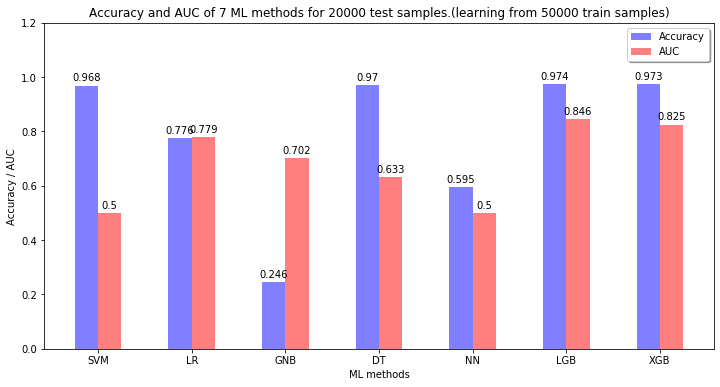

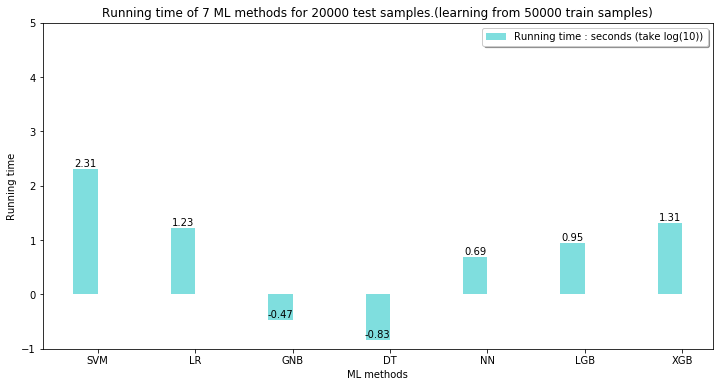

In [35]:
import math
best_acc=[best_acc_svm,best_acc_LR,best_acc_GNB,best_acc_DT,best_acc_NN,best_acc_LGB,best_acc_XGB]
best_auc=[best_auc_svm,best_auc_LR,best_auc_GNB,best_auc_DT,best_auc_NN,best_auc_LGB,best_auc_XGB]
best_rt=[math.log10(i) for i in [best_rt_svm,best_rt_LR,best_rt_GNB,best_rt_DT,best_rt_NN,best_rt_LGB,best_rt_XGB]]
#print(best_acc,best_auc,best_rt)
Results_comparison_1(best_acc,best_auc)
Results_comparison_2(best_rt)